## Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from datetime import datetime as dat
import pickle
# import re
from statistics import mode
# from pathlib import Path

import time


# preprocessing tool
# from sklearn.preprocessing import StandardScaler

# modeling tool
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline

# Classification models
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

# novelty detection models
# from sklearn.svm import OneClassSVM
# from  sklearn.ensemble import IsolationForest
# from  sklearn.neighbors import LocalOutlierFactor


# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_recall_fscore_support 

import warnings
warnings.filterwarnings('ignore')

## Helper Functions to extract flow metrics from traffic flow data and for the modeling
from helpers import read_multifiles, make_modeling_data, make_attack_model, attack_detector
 

## Modeling

#### Feature Engineering 
Extract flow data and make the training data

In [2]:
# # # read all data
# train = read_multifiles(basepath = '../data/large_data/data_2509/train', datalist = [], pickle_file=False)
# # [print(n.name[0]) for n in train]   # view the arrangement of the files
# normal_hive_ipaddr = "192.168.0.101"
# device_ipadd = "192.168.0.102"
# attack_ipadd = "192.168.0.103"
# training_df = make_modeling_data(train, device_ipadd, attack_ipadd, df_name='Train', roller=7, step=2, save_to_csv=True)

# # or 

training_df = pd.read_csv('../data/Training_data/train_v1.0.csv')

training_df

,Unnamed: 0,pkt_start,pkt_end,flow_dur,ave_pack_IAT,count_tcp_flags,count_syn_flag,count_ack_flag,count_fin_flag,count_rst_flag,...,count_tcp,count_tls,count_icmp,count_udp,count_ntp,count_dns,no_unique_prot,no_unique_pl,sn_type,label
0,0,0,9,15.811,1.756778,1,0,0,0,0,...,0,0,9,0,0,0,1,1,-1,ICMP02
1,1,2,11,1.510,0.167778,1,0,0,0,0,...,0,0,9,0,0,0,1,1,-1,ICMP02
2,2,4,13,1.510,0.167778,1,0,0,0,0,...,0,0,9,0,0,0,1,1,-1,ICMP02
3,3,6,15,2.228,0.247556,1,0,0,0,0,...,0,0,9,0,0,0,1,1,-1,ICMP02
4,4,8,17,2.228,0.247556,1,0,0,0,0,...,0,0,9,0,0,0,1,1,-1,ICMP02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456816,456816,284816,284825,0.000,0.000000,1,0,0,0,0,...,0,0,0,9,0,0,1,1,-1,UDP03
456817,456817,284818,284827,0.000,0.000000,1,0,0,0,0,...,0,0,0,9,0,0,1,1,-1,UDP03
456818,456818,284820,284827,0.000,0.000000,1,0,0,0,0,...,0,0,0,7,0,0,1,1,-1,UDP03
456819,456819,284822,284827,0.000,0.000000,1,0,0,0,0,...,0,0,0,5,0,0,1,1,-1,UDP03


### EDA

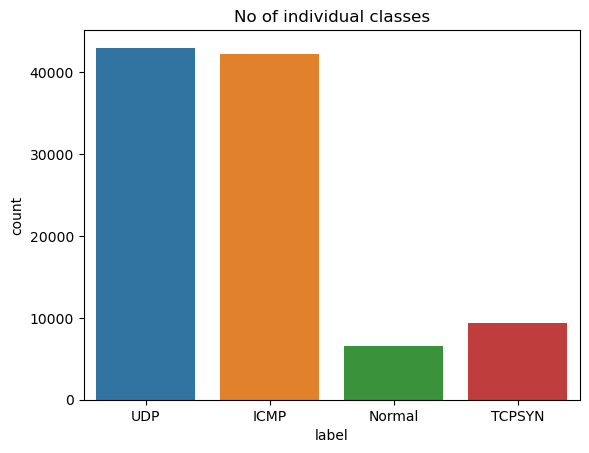

,pkt_start,pkt_end,flow_dur,ave_pack_IAT,count_tcp_flags,count_syn_flag,count_ack_flag,count_fin_flag,count_rst_flag,count_psh_flag,count_tcp,count_tls,count_icmp,count_udp,count_ntp,count_dns,no_unique_prot,no_unique_pl,sn_type,label
0,123680,123689,0.440,0.048889,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
1,446008,446017,1.133,0.125889,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
2,92228,92237,0.507,0.056333,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
3,240596,240605,8.675,0.963889,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
4,209788,209797,0.000,0.000000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
5,338514,338523,2.674,0.297111,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
6,6986,6995,0.000,0.000000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
7,384566,384575,2.097,0.233000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
8,148334,148343,1.222,0.135778,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP
9,54288,54297,0.000,0.000000,1,0,0,0,0,0,0,0,0,9,0,0,1,1,-1,UDP


In [93]:
#1 read in flow data 
data = training_df.iloc[:,1:]
data.label = data.label.apply(lambda x: x[:-2]) # clean the label names

# sample from the large UDP data
np.random.seed(1)
data = pd.concat([data.query('label == "UDP"').sample(43000), 
          data.query('label != "UDP"')]
          , ignore_index=True)

# EDA
plot = sns.countplot(x= 'label', data = data,
                    hue='label', palette= "tab10"
                   )
plot.set(title = "No of individual classes")
plt.show()

data.head(10)

In [94]:
# address class inbalance
from imblearn.over_sampling import  RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = oversample.fit_resample(data.iloc[:, data.columns != "label"], data['label'])

flow_data = X_over
flow_data['label'] = y_over

flow_data.label.value_counts()

UDP       43000
ICMP      43000
Normal    43000
TCPSYN    43000
Name: label, dtype: int64

### Train models

Here we trained various ensembled and support machine models


 ========== Random Forest ==========


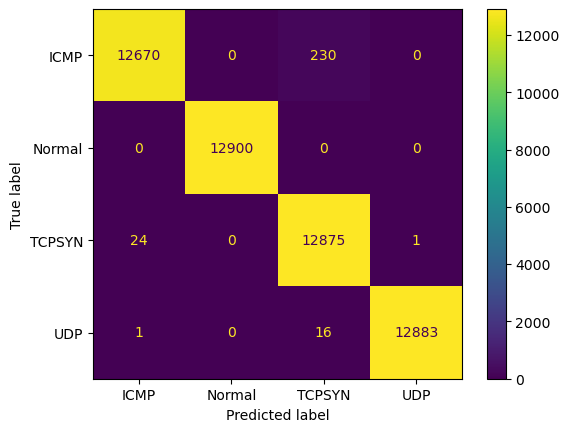

                ICMP   Normal     TCPSYN        UDP
precision      0.998      1.0      0.981      1.000
recall         0.982      1.0      0.998      0.999
fscore         0.990      1.0      0.990      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.9947286821705427
f1_score:  0.9947310860481844


 ========== SVM ==========


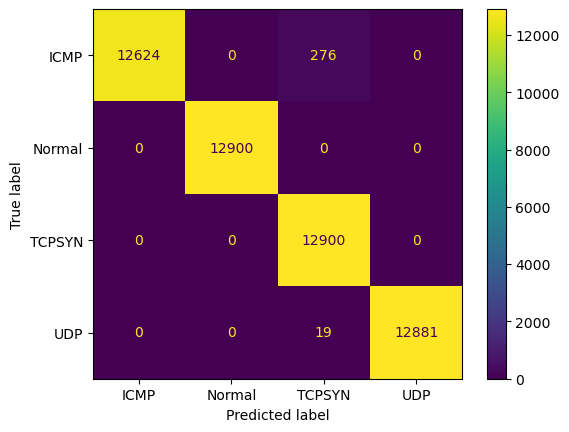

                ICMP   Normal     TCPSYN        UDP
precision      1.000      1.0      0.978      1.000
recall         0.979      1.0      1.000      0.999
fscore         0.989      1.0      0.989      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.994282945736434
f1_score:  0.9942862058363643


 ========== Gradient Boosting ==========


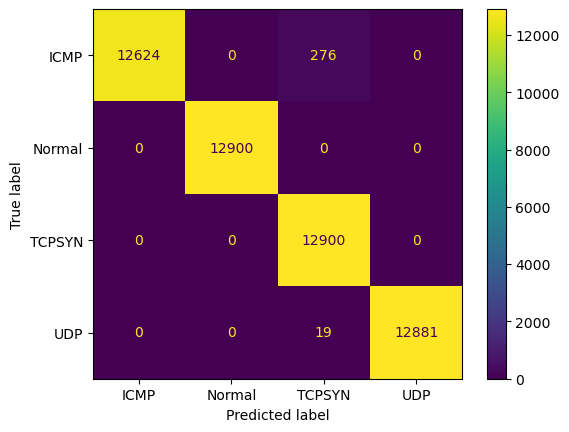

                ICMP   Normal     TCPSYN        UDP
precision      1.000      1.0      0.978      1.000
recall         0.979      1.0      1.000      0.999
fscore         0.989      1.0      0.989      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.994282945736434
f1_score:  0.9942862058363643


 ========== Ensemble by voting ==========


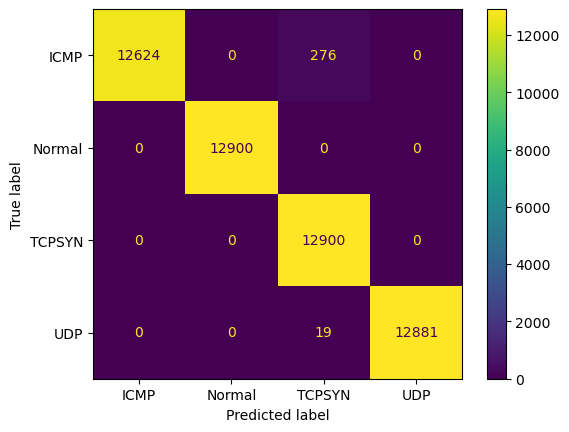

                ICMP   Normal     TCPSYN        UDP
precision      1.000      1.0      0.978      1.000
recall         0.979      1.0      1.000      0.999
fscore         0.989      1.0      0.989      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.994282945736434
f1_score:  0.9942862058363643


 ========== Stacked generalization ==========


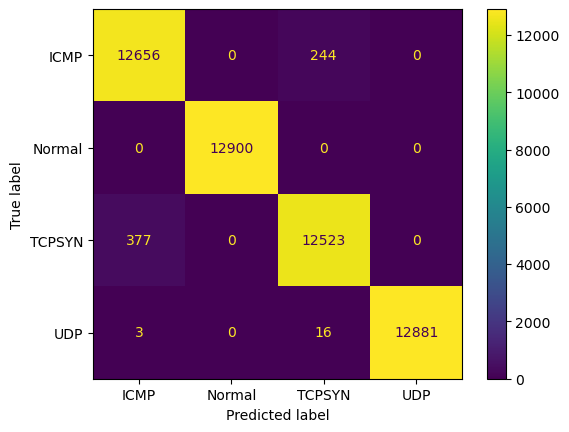

                ICMP   Normal     TCPSYN        UDP
precision      0.971      1.0      0.980      1.000
recall         0.981      1.0      0.971      0.999
fscore         0.976      1.0      0.975      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.9875968992248061
f1_score:  0.9876003504952133


 ========== Ada Boost Classifier ==========


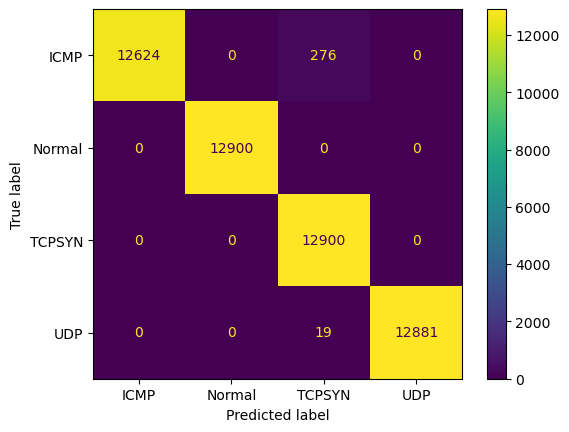

                ICMP   Normal     TCPSYN        UDP
precision      1.000      1.0      0.978      1.000
recall         0.979      1.0      1.000      0.999
fscore         0.989      1.0      0.989      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.994282945736434
f1_score:  0.9942862058363643



In [95]:
nb = GaussianNB()
rf = RandomForestClassifier(n_estimators=10, random_state=1) 
svm =  LinearSVC(random_state=0, tol=1e-5)
estimators=[('nb', nb), ('rf', rf), ('svm', svm)]

models = [RandomForestClassifier(random_state=10), LinearSVC(random_state=0, tol=1e-5),
          HistGradientBoostingClassifier(max_iter=100), VotingClassifier(estimators=estimators, voting='hard'),
          StackingClassifier(estimators=estimators, final_estimator= RandomForestClassifier(random_state=10)),  AdaBoostClassifier(n_estimators=100)]
model_names = ["Random Forest", "SVM", "Gradient Boosting", "Ensemble by voting", "Stacked generalization", "Ada Boost Classifier"]
models_df = pd.DataFrame()

for clf, name in zip(models, model_names):
    start = time.perf_counter()
    print("\n", "="*10, name, "="*10)
    _,_, scores = make_attack_model(flow_data, clf, scale=True) # for use during prediction 
    # print("Total run time is {:0.2f} seconds".format(time.perf_counter() - start))

    scores["name"] = name
    scores["time"] = time.perf_counter() - start
    models_df = models_df.append(scores, ignore_index=True)
    print()

In [101]:
models_df.to_excel("../data/Ensemble_model_result.xlsx")
# models_df =pd.read_excel("../data/Ensemble model result.xlsx")

models_df.sort_values(by = ['f1_score'], ascending=False)

,Balance Accuracy,f1_score,name,time
0,0.994729,0.994731,Random Forest,14.430699
1,0.994283,0.994286,SVM,27.998523
2,0.994283,0.994286,Gradient Boosting,5.780776
3,0.994283,0.994286,Ensemble by voting,27.351088
5,0.994283,0.994286,Ada Boost Classifier,37.339183
4,0.987597,0.987600,Stacked generalization,136.404501


## Best model

Best model is selected based on f1_score


 ========== Randon Forest ==========


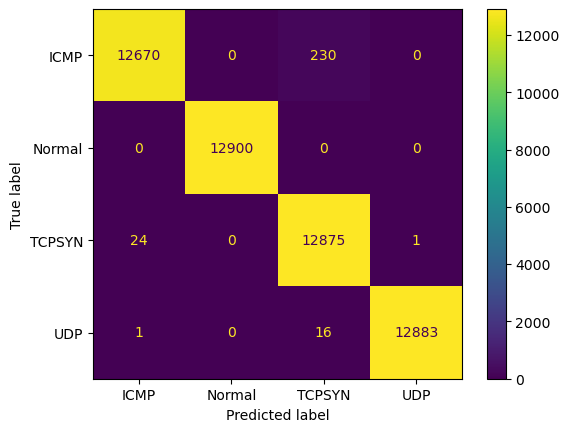

                ICMP   Normal     TCPSYN        UDP
precision      0.998      1.0      0.981      1.000
recall         0.982      1.0      0.998      0.999
fscore         0.990      1.0      0.990      0.999
support    12900.000  12900.0  12900.000  12900.000
Balance Accuracy:  0.9947286821705427
f1_score:  0.9947310860481844


In [98]:
# best model
print("\n", "="*10, "Randon Forest", "="*10)
best_clf =  RandomForestClassifier(random_state=10)
model, scaler, score = make_attack_model(flow_data, best_clf, scale=True) # for use during prediction 

# save model and scaler 
pickle.dump(scaler, open('../models/b_model/scaler', 'wb'))  
pickle.dump(model, open('../models/b_model/model', 'wb'))

## Detection

### Testing data

In [99]:
# Load the trained model for continous monitoring
trained_scaler = pickle.load(open('../models/b_model/scaler', 'rb')) 
trained_model = pickle.load(open('../models/b_model/model', 'rb'))

In [ ]:
device_ipadd = "192.168.0.102"

test = read_multifiles(basepath = '../data/large_data/data_2509/test', pickle_file=False)

# Read the data (detection - get traffic data)
for i in range(len(test)):
    traffic_df = test[i].copy()
    print('\n', '='*10, 'processing', set(traffic_df.name), '='*15)
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd, roller = 7)
    print('='*70)

# traffic_df = pd.read_csv('../data/large_data/data_2509/trial/normal.csv', encoding='latin1',  parse_dates = ['Time'])
# atk_name,_,_,_ =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 47)

### Validation data

In [ ]:
val = read_multifiles(basepath = '../data/large_data/data_2509/val', pickle_file=False)
device_ipadd = "192.168.0.102"

# Read the data (detection - get traffic data)
for i in range(len(val)):
    traffic_df = val[i].copy()
    print('\n', '='*10, 'processing', set(traffic_df.name), '='*15)
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd, roller = 7)
    print('='*70)

processing: HTTPDDOS01.csv
processing: HTTPDDOS02.csv
processing: HTTPDDOS03.csv
processing: REC,UDP,TCP,HTTP DDOS01.csv
processing: RECOILDDOS01X1.csv
processing: SLOWLOIC01X1.csv
processing: SLOWLOIC02X1.csv
processing: TCP,UDP,ICMP,HTTP DDOS03.csv
processing: TCP,UDP,ICMPHTTP DDOS02.csv
All files have now been loaded

 ========== processing {'ICMP01'} ===============
"ICMP" Attack(attack mode - ['ICMP']) detected between packet ==> 88 and 97 (original index 581 : 610)
                 stop server NOW

 ========== processing {'ICMP05'} ===============
"ICMP" Attack(attack mode - ['ICMP']) detected between packet ==> 88 and 97 (original index 281 : 299)
                 stop server NOW

 ========== processing {'TCPSYN02'} ===============
"TCPSYN" Attack(attack mode - ['TCP']) detected between packet ==> 98 and 107 (original index 272 : 293)
                 stop server NOW

 ========== processing {'TCPSYN03'} ===============
"ICMP" Attack(attack mode - ['TCP']) detected between packet

### Public dataset

In [31]:
# Read the data (detection - get traffic data)
p_test = read_multifiles(basepath = '../data/large_data/data_2509/public', datalist = [], pickle_file=False)
# p_test2 = read_multifiles(basepath = '../data/large_data/data_2509/public/special', datalist = [], pickle_file=False)

# # filter out noise
# p_test2[0] = p_test2[0][11549:]
# p_test2[1] = p_test2[1][11462:]

p_test_device_ipadd = "192.168.1.158"
# p_test2_device_ipadd = "192.168.100.3"

# Read the data (detection - get traffic data)
for i in range(len(p_test)):
    traffic_df = p_test[i].copy()
    print('\n', '='*10, 'processing', set(traffic_df.name), '='*15)
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, p_test_device_ipadd, roller = 7)
    # atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, device_ipadd=None, roller = 7)
    print('='*70)

# # Read the data (detection - get traffic data)
# for i in range(len(p_test2)):
#     traffic_df = p_test2[i].copy()
#     print('\n', '='*15, 'processing', set(traffic_df.name), '='*15)
#     atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, trained_model, trained_scaler, p_test2_device_ipadd, roller = 7)
#     print('='*70)

Loading: publicBenignA 192.168.1.158.csv
Loading: publicBenignB 192.168.1.158.csv
Loading: publicbenignC 192.168.1.158.csv
Loading: publicbenignD 192.168.1.158.csv
Loading: publicbenignE 192.168.1.158.csv
All files have now been loaded

 ========== processing {'publicBenignA 192.168.1.158'} ===============
"UDP" Attack(attack mode - ['DNS']) detected between packet ==> 1646 and 1655 (original index 3397 : 3416)
                 stop server NOW

 ========== processing {'publicBenignB 192.168.1.158'} ===============
"UDP" Attack(attack mode - ['DNS']) detected between packet ==> 358 and 367 (original index 741 : 758)
                 stop server NOW

 ========== processing {'publicbenignC 192.168.1.158'} ===============

 ========== processing {'publicbenignD 192.168.1.158'} ===============
"UDP" Attack(attack mode - ['TCP']) detected between packet ==> 30402 and 30406 (original index 62841 : 62844)
                 stop server NOW

 ========== processing {'publicbenignE 192.168.1.158'} 